In [ ]:
!pip install keras-cv==0.6.1 keras-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.2/756.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 49.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import optimizers
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
import resource
from keras_cv import visualization
import tqdm
import json

Using TensorFlow backend


In [ ]:
path_to_downloaded_file = keras.utils.get_file(
    origin="https://archive.org/download/self-driving-car.v-3-fixed-small.coco/Self%20Driving%20Car.v3-fixed-small.coco.zip",
    extract=True,
)

1226687196/1226687196 [==============================] - 679s 1us/step


In [ ]:
path_to_downloaded_file

'/root/.keras/datasets/Self%20Driving%20Car.v3-fixed-small.coco.zip'

In [ ]:
!unzip '/root/.keras/datasets/Self%20Driving%20Car.v3-fixed-small.coco.zip' -d .

Streaming output truncated to the last 5000 lines.
 extracting: ./export/1478900100165707353_jpg.rf.mLJlW3Cf3VoVKjXY6jgh.jpg  
 extracting: ./export/1478900100737478288_jpg.rf.2bb35a1222e15394de7033687f69065c.jpg  
 extracting: ./export/1478900100737478288_jpg.rf.nbrgBfnnhHP0mwGGKfnW.jpg  
 extracting: ./export/1478900101309115339_jpg.rf.2508668be11307c87ff954cf21544d10.jpg  
 extracting: ./export/1478900101309115339_jpg.rf.OsDb7MLdxcxdujSvvLyR.jpg  
 extracting: ./export/1478900101879688623_jpg.rf.81c3be06336e0ae02178f47713d58e6f.jpg  
 extracting: ./export/1478900101879688623_jpg.rf.v2nxcO0TVyrQn6VcGa1D.jpg  
 extracting: ./export/1478900102451943901_jpg.rf.4kwTUlpUEj4Jc9ubppWJ.jpg  
 extracting: ./export/1478900102451943901_jpg.rf.bb6b07a82d52b84fdcc5593bc581128c.jpg  
 extracting: ./export/1478900103022167413_jpg.rf.RQ4U0fNDAki55lA9GdEG.jpg  
 extracting: ./export/1478900103022167413_jpg.rf.e6e06a954b166e3767e86f06099eae5c.jpg  
 extracting: ./export/1478900103593304251_jpg.rf.VMyb

In [ ]:
!ls

export	README.dataset.txt  README.roboflow.txt  sample_data


In [ ]:
!ls export

Streaming output truncated to the last 5000 lines.
1478900100165707353_jpg.rf.02dae94790fe0a5fd8145e6582060381.jpg
1478900100165707353_jpg.rf.mLJlW3Cf3VoVKjXY6jgh.jpg
1478900100737478288_jpg.rf.2bb35a1222e15394de7033687f69065c.jpg
1478900100737478288_jpg.rf.nbrgBfnnhHP0mwGGKfnW.jpg
1478900101309115339_jpg.rf.2508668be11307c87ff954cf21544d10.jpg
1478900101309115339_jpg.rf.OsDb7MLdxcxdujSvvLyR.jpg
1478900101879688623_jpg.rf.81c3be06336e0ae02178f47713d58e6f.jpg
1478900101879688623_jpg.rf.v2nxcO0TVyrQn6VcGa1D.jpg
1478900102451943901_jpg.rf.4kwTUlpUEj4Jc9ubppWJ.jpg
1478900102451943901_jpg.rf.bb6b07a82d52b84fdcc5593bc581128c.jpg
1478900103022167413_jpg.rf.e6e06a954b166e3767e86f06099eae5c.jpg
1478900103022167413_jpg.rf.RQ4U0fNDAki55lA9GdEG.jpg
1478900103593304251_jpg.rf.bd8db7e918ad273e4eb7c5a54b719330.jpg
1478900103593304251_jpg.rf.VMybNILqwMvLMRzohJRi.jpg
1478900104166175129_jpg.rf.29b016a9d18cb696814f53d24fd833fc.jpg
1478900104166175129_jpg.rf.tMcNFNQZMX7v9Axxj2Sj.jpg
1478900104736157289_j

In [ ]:
with open('export/_annotations.coco.json') as f:
  j = json.load(f)

In [ ]:
class_mapping = {c['id']: c['name'] for c in j['categories']}
class_mapping

{0: 'obstacles',
 1: 'biker',
 2: 'car',
 3: 'pedestrian',
 4: 'trafficLight',
 5: 'trafficLight-Green',
 6: 'trafficLight-GreenLeft',
 7: 'trafficLight-Red',
 8: 'trafficLight-RedLeft',
 9: 'trafficLight-Yellow',
 10: 'trafficLight-YellowLeft',
 11: 'truck'}

In [ ]:
image_paths = [f"export/{d['file_name']}" for d in j['images']]

In [ ]:
classes = [[] for _ in image_paths]
bounding_boxes = [[] for _ in image_paths]

In [ ]:
for a in j['annotations']:
  idx = a['image_id']
  classes[idx].append(a['category_id'])
  bounding_boxes[idx].append(a['bbox'])

In [ ]:
classes[:5]

[[2, 2, 2, 2], [], [2, 3, 2, 2, 2, 2, 2, 2], [7, 7, 3, 3, 2, 2], [2, 2]]

In [ ]:
no_annotations = [len(x) == 0 for x in classes]

In [ ]:
np.sum(no_annotations)

3500

In [ ]:
# image_paths = [x for x, na in zip(image_paths, no_annotations) if not na]

In [ ]:
len(image_paths)

29800

In [ ]:
# len(classes)

In [ ]:
# classes = [x for x, na in zip(classes, no_annotations) if not na]
# bounding_boxes = [x for x, na in zip(bounding_boxes, no_annotations) if not na]

In [ ]:
bbox = tf.ragged.constant(bounding_boxes)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

In [ ]:
len(data)

29800

In [ ]:
smalldata = data.take(10_000)

In [ ]:
len(smalldata)

10000

In [ ]:
val_data = smalldata.take(2_000)
train_data = smalldata.skip(2_000)

In [ ]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {
        "images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [ ]:
# Hyperparams
BATCH_SIZE = 4

In [ ]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(
            mode="horizontal", bounding_box_format="xywh"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xywh"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640),
            scale_factor=(0.75, 1.3),
            bounding_box_format="xywh"
        ),
    ]
)

In [ ]:
# Create train dataset
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Create validation dataset
resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format="xywh", pad_to_aspect_ratio=True
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

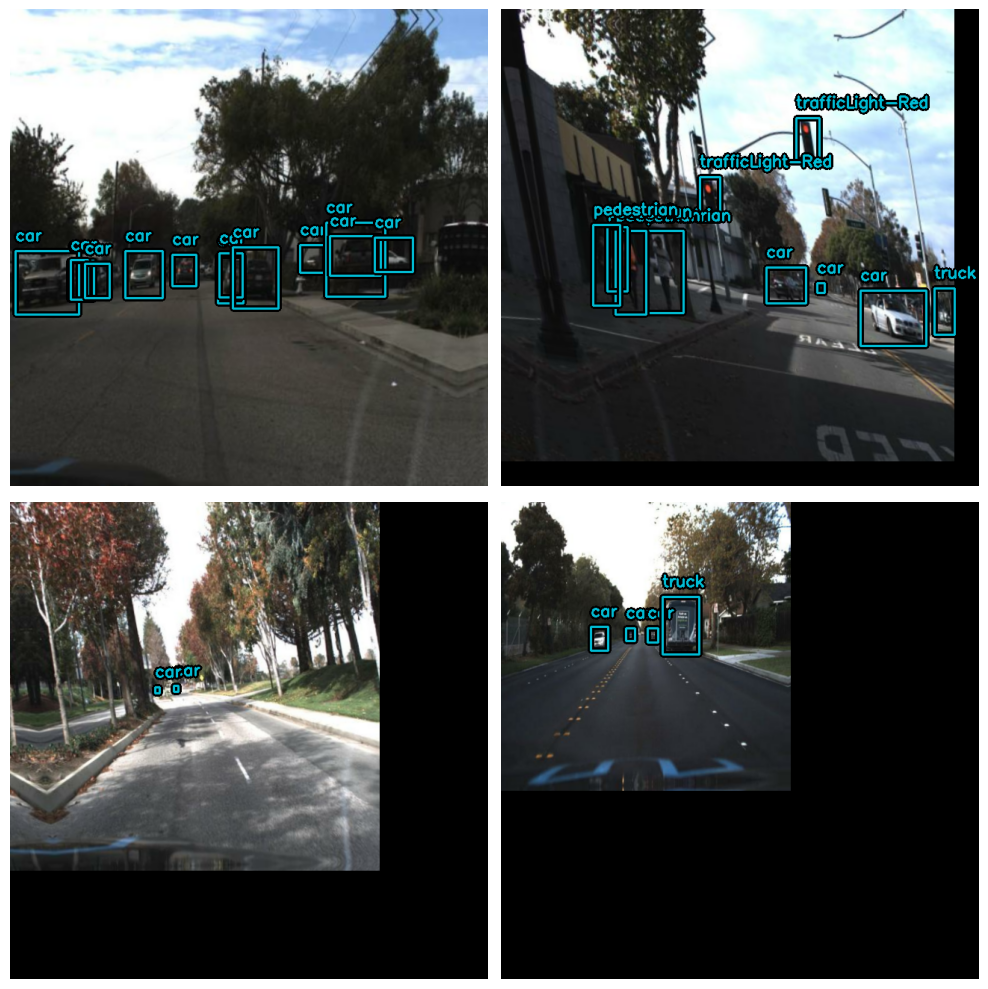

In [ ]:
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

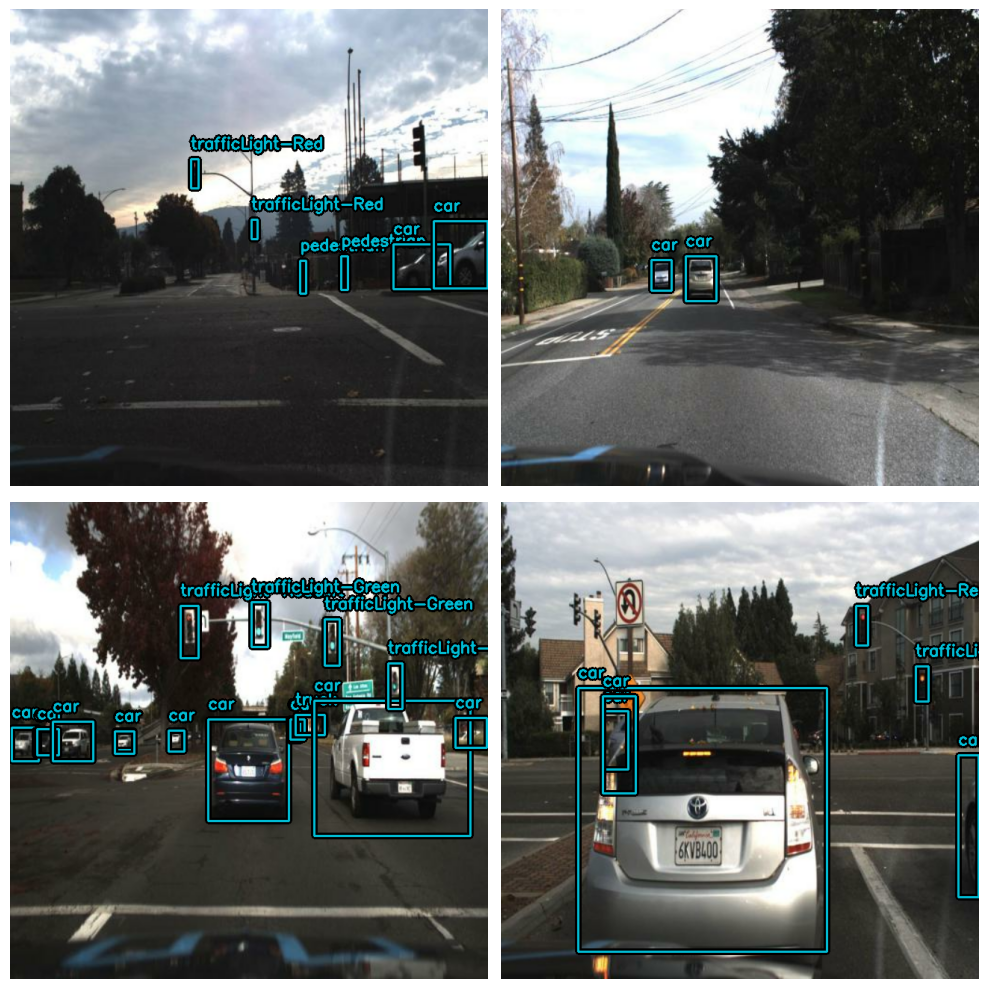

In [ ]:
visualize_dataset(
    val_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

In [ ]:
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
# Global clipnorm helps to reduce exploding gradient

base_lr = 0.005
# including a global_clipnorm is extremely important in object detection tasks
optimizer = tf.keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)

In [ ]:
# Creates a "RetinaNet" from ResNet50 backbone

model = keras_cv.models.RetinaNet.from_preset(
    "resnet50_imagenet",
    num_classes=len(class_mapping),
    bounding_box_format="xywh",
)

94657128/94657128 [==============================] - 6s 0us/step


In [ ]:
model.compile(
    classification_loss="focal",
    box_loss="smoothl1",
    optimizer=optimizer,
)

In [ ]:
print("TensorFlow version:", tf.__version__)

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU")
except ValueError:
    tpu = None
    print("Running on GPU or CPU")

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("Number of replicas:", strategy.num_replicas_in_sync)

TensorFlow version: 2.14.0
Running on GPU or CPU
Number of replicas: 1


In [ ]:
with strategy.scope():
  model.fit(
      train_ds.take(20),
      validation_data=val_ds.take(20),
      epochs=10,
  )


Epoch 1/10
20/20 [==============================] - 60s 930ms/step - loss: 1.5228 - box_loss: 0.6662 - classification_loss: 0.8566 - percent_boxes_matched_with_anchor: 0.8031 - val_loss: 1.3601 - val_box_loss: 0.6565 - val_classification_loss: 0.7035 - val_percent_boxes_matched_with_anchor: 0.8199
Epoch 2/10
20/20 [==============================] - 16s 795ms/step - loss: 1.2732 - box_loss: 0.6251 - classification_loss: 0.6480 - percent_boxes_matched_with_anchor: 0.7937 - val_loss: 1.2691 - val_box_loss: 0.6189 - val_classification_loss: 0.6502 - val_percent_boxes_matched_with_anchor: 0.8188
Epoch 3/10
20/20 [==============================] - 15s 729ms/step - loss: 1.1364 - box_loss: 0.5987 - classification_loss: 0.5377 - percent_boxes_matched_with_anchor: 0.8059 - val_loss: 1.1889 - val_box_loss: 0.5987 - val_classification_loss: 0.5902 - val_percent_boxes_matched_with_anchor: 0.8262
Epoch 4/10
20/20 [==============================] - 16s 760ms/step - loss: 1.0646 - box_loss: 0.5735 - 

In [ ]:
# Let's create a simple function to plot our inferences
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=4,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

In [53]:
# Set IoU and confidence threshold
model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.2,
)

In [54]:
# construct a dataset with larger batches:
visualization_ds = val_ds.unbatch()
visualization_ds = visualization_ds.ragged_batch(16)
visualization_ds = visualization_ds.shuffle(8)

1/1 [==============================] - 2s 2s/step


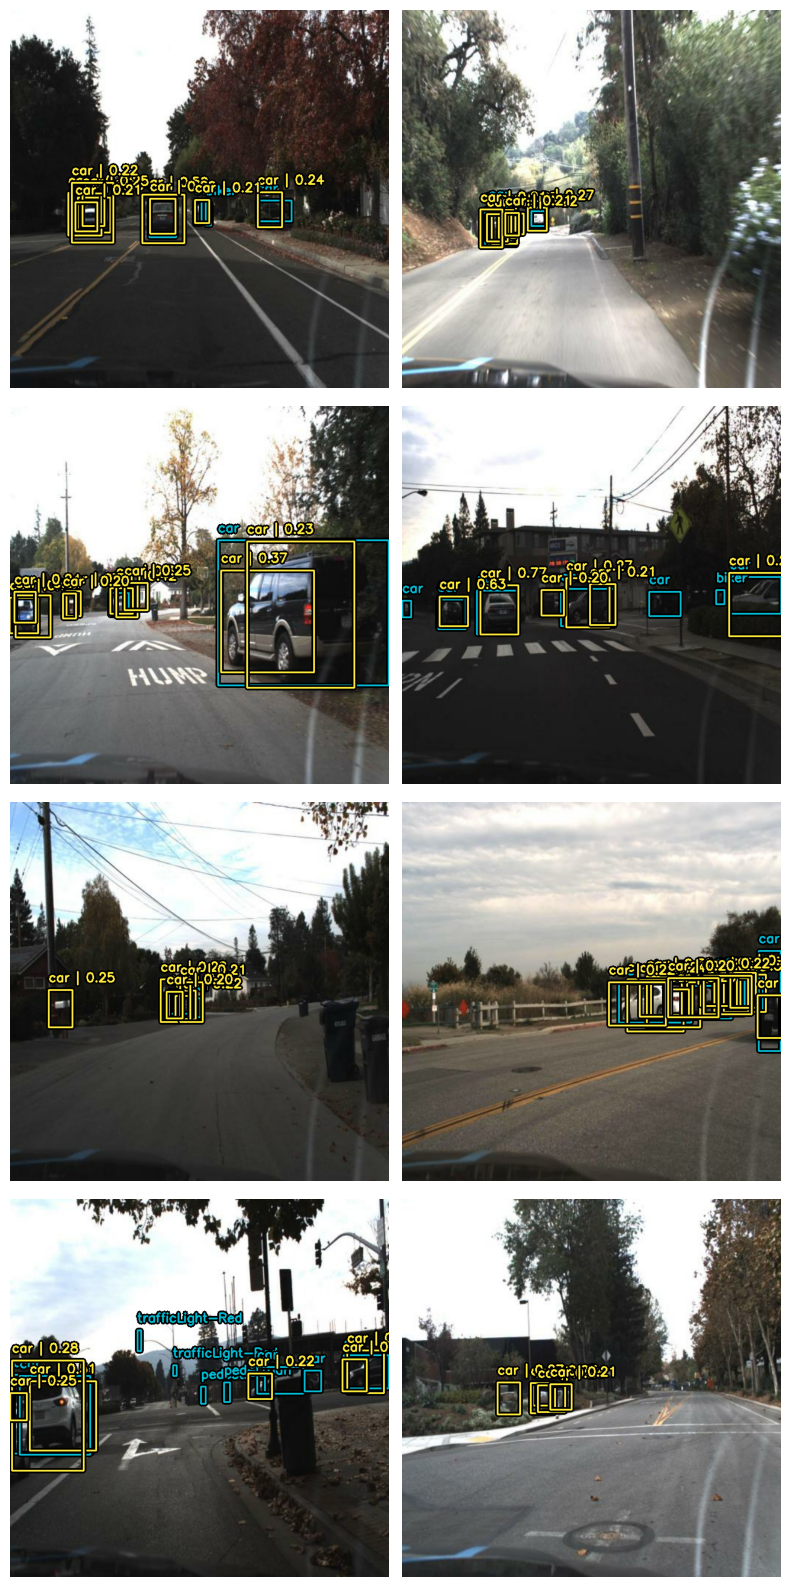

In [55]:
visualize_detections(model, dataset=visualization_ds, bounding_box_format="xywh")

![](https://deeplearningcourses.com/notebooks_v3_pxl?sc=pUMo7qJJA-9KZG32o7CO7A&n=Train+Object+Detection+Custom+Dataset)